In [1]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

In [2]:
def fnact(X):       ### Activation function
    #return np.tanh(X)
    #return 1. / (1. + np.exp(-X))       # sigmoid
    t = np.copy(X)          # ReLU
    t[X < 0] = 0.
    return t


In [4]:
def dfnact(A):      ### backprop of Activation function, A = fnact(X), A is not X
    #return  1. - np.power(A, 2)        # backprop of tanh
    #return A * (1. - A)                 # backprop of sigmoid
    t = np.copy(A)          # backprop of ReLU
    t[A < 0] = 0.
    return t

In [23]:
class Config:
    nn_input_dim = 2  # input layer dimensionality
    nn_output_dim = 2  # output layer dimensionality
    # Gradient descent parameters (I picked these by hand)
    epsilon = 0.01  # learning rate for gradient descent
    reg_lambda = 0.01 

In [7]:

def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

In [9]:

def visualize(X, y, model):
    # plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
    # plt.show()
    plt.title("Logistic Regression")
    plot_decision_boundary(lambda x:predict(model,x), X, y)

In [13]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [14]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y):
    num_examples = len(X)  # training set size
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    #a1 = np.tanh(z1)
    a1 = fnact(z1)                                                              #### use fncat()
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += Config.reg_lambda / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1. / num_examples * data_loss


In [16]:
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    #a1 = np.tanh(z1)
    a1 = fnact(z1)                                                      ### use fnact()
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [18]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(X, y, nn_hdim, num_passes=20000, print_loss=False):
    # Initialize the parameters to random values. We need to learn these.
    num_examples = len(X)
    np.random.seed(0)
    W1 = np.random.randn(Config.nn_input_dim, nn_hdim) / np.sqrt(Config.nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, Config.nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, Config.nn_output_dim))

    # This is what we return at the end
    model = {}

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        #a1 = np.tanh(z1)
        a1 = fnact(z1)                                      ### use fnact()
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        #delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        delta2 = delta3.dot(W2.T) * dfnact(a1)              ### use dfnact()
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += Config.reg_lambda * W2
        dW1 += Config.reg_lambda * W1

        # Gradient descent parameter update
        W1 += -Config.epsilon * dW1
        b1 += -Config.epsilon * db1
        W2 += -Config.epsilon * dW2
        b2 += -Config.epsilon * db2

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

# Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" % (i, calculate_loss(model, X, y)))

        return model




In [19]:
def classify(X, y):
    # clf = linear_model.LogisticRegressionCV()
    # clf.fit(X, y)
    # return clf

    pass



In [32]:

def main():
    X, y = generate_data()
    #mask = np.random.choice(200, 50)                                ### add 1 line
    #model = build_model(X[mask], y[mask], 3, print_loss=True)       ### add [mask]
    model = build_model(X, y, 3, print_loss=True)
    visualize(X, y, model)

Loss after iteration 0: 0.575285


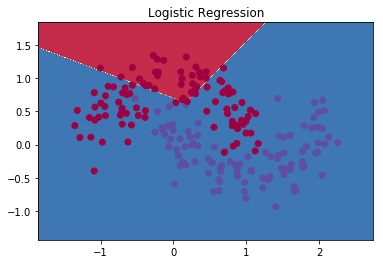

In [33]:
main()